In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
from collections import defaultdict
warnings.filterwarnings('ignore')

def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [22]:
# import dataset 
private_data = "../datasets/cleaned/cleaned_private.csv"

df = pd.read_csv(private_data, quotechar='"', escapechar='\\', thousands=',')

In [23]:
# Preprocess data: Extract 'Sale Month-Year' from 'Sale Date'
df['Sale Month-Year'] = pd.to_datetime(df['Sale Date']).dt.to_period('M').astype(str)

#choose features to train model
selected_features = [
    'Area (SQFT)',
    'Postal District',
    'Market Segment',
    'Property Type',
    'Floor Level',
    'Distance to MRT (km)',
    'Sale Month-Year',
    'Lease_Category'
]

#select feature to predict
target = 'Price'

#remove price outliers
df = remove_outliers_iqr(df, 'Price')

#create a new df with only these features
df_selected = df[selected_features + [target]].copy()

categorical_cols = ['Postal District', 'Market Segment', 'Property Type', 'Floor Level', 'Lease_Category', 'Sale Month-Year']
numerical_cols = ['Area (SQFT)', 'Distance to MRT (km)']

categorical_cols_to_check = [col for col in categorical_cols]
df_selected.dropna(subset=categorical_cols_to_check, inplace=True)

In [24]:
# train test split
X = df_selected.drop(target, axis=1)
y = df_selected[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=40))
])

# train model
rf_model.fit(X_train, y_train)

# make predictions
y_pred = rf_model.predict(X_test)

In [ ]:
#print stats
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"1. Mean Squared Error (MSE): {mse:.2f}")
print(f"2. Mean Absolute Error (MAE): {mae:.2f}")
print(f"3. R² Score: {r2:.4f}")


Model Evaluation:
1. Mean Squared Error (MSE): 667998382695.40
2. Mean Absolute Error (MAE): 169484.19
3. R² Score: 0.8474


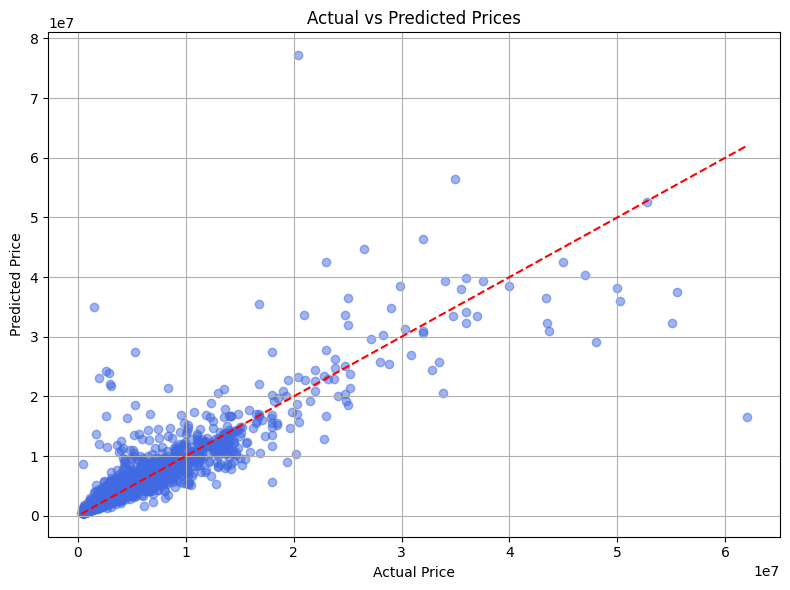

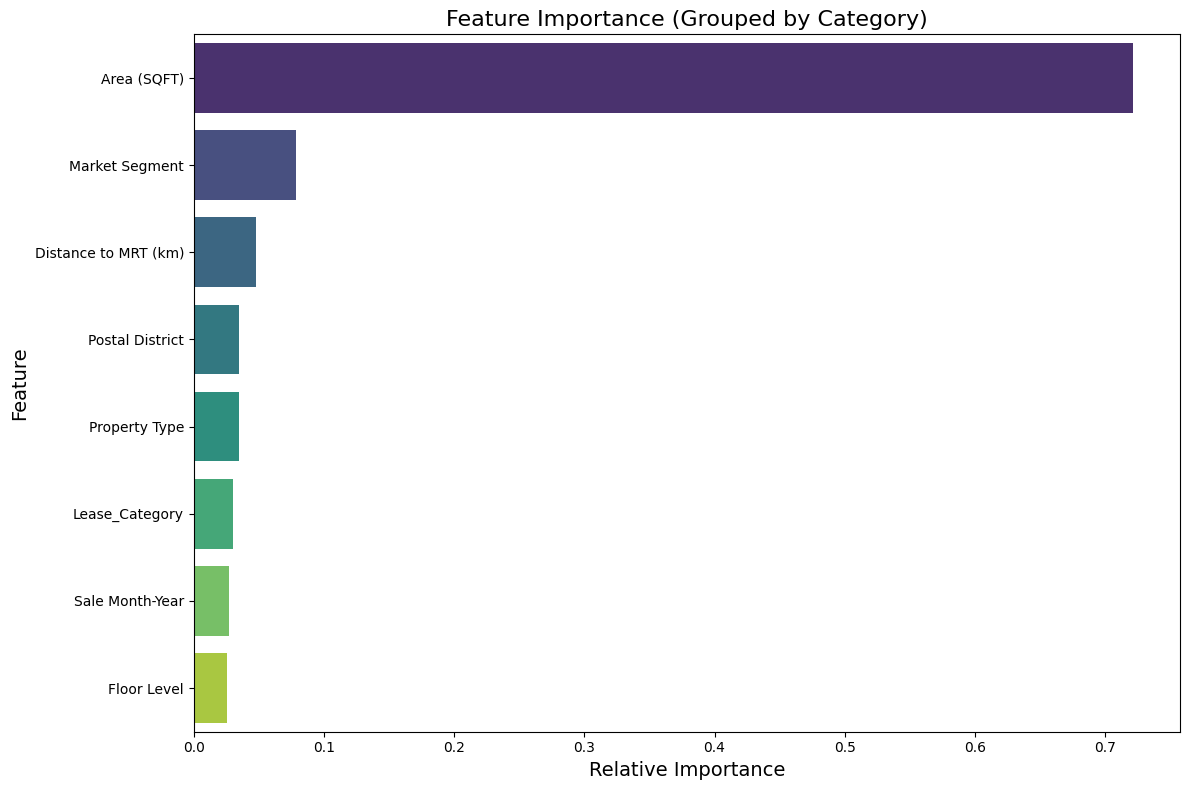


Feature Importance Ranking:
Area (SQFT): 0.7215
Market Segment: 0.0783
Distance to MRT (km): 0.0478
Postal District: 0.0349
Property Type: 0.0347
Lease_Category: 0.0301
Sale Month-Year: 0.0270
Floor Level: 0.0257


In [ ]:
plt.figure(figsize=(8, 6),  facecolor='none')
ax = plt.axes()
ax.patch.set_alpha(0) 
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract feature importances
feature_importance = rf_model.named_steps['regressor'].feature_importances_

# Get the feature names from the preprocessor
ohe = rf_model.named_steps['preprocessor'].transformers_[1][1]
cat_features = ohe.get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numerical_cols, cat_features])

# Create a mapping from feature names to their importance
importances = dict(zip(feature_names, feature_importance))

# Group by original feature categories
grouped_importances = defaultdict(float)

# Add numerical features directly
for col in numerical_cols:
    grouped_importances[col] = importances[col]

# Sum up importances for each categorical feature
for full_feature_name in cat_features:
    # Extract original feature name from the transformed feature name
    # The format is typically: feature_category_value
    # We need to get back to the original category
    for cat_col in categorical_cols:
        if cat_col in full_feature_name:
            grouped_importances[cat_col] += importances[full_feature_name]
            break

# Convert to DataFrame for easier plotting
importance_df = pd.DataFrame({
    'Feature': list(grouped_importances.keys()),
    'Importance': list(grouped_importances.values())
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8), facecolor='none')
ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', alpha=0.8)  # Semi-transparent bars
ax.patch.set_alpha(0)  # Transparent axes background
plt.title('Feature Importance (Grouped by Category)', fontsize=16)
plt.xlabel('Relative Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

# For additional insights, you can also print the values
print("\nFeature Importance Ranking:")
for idx, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")
